In [1]:
import os
import numpy as np
import pandas as pd
import pyswarm
import scipy.stats as sps

import argus_shapes
import pulse2percept.implants as p2pi
from pulse2percept.retina import ret2dva, dva2ret

import sklearn.base as sklb
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-07 11:46:10,013 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
y_trial = {}
y_mean = {}
for subject in subjects:
    X, y = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'),
                                  subject=subject, amp=2.0, random_state=42)
    y_trial[subject] = y
    _, y_mean[subject] = argus_shapes.calc_mean_images(X, y, max_area=1.5)

In [5]:
import pulse2percept as p2p
from matplotlib import patches
def plot_orientation(subject, y_mean, subjectdata):
    implant_type = subjectdata.loc[subject, 'implant_type']
    implant_rot = subjectdata.loc[subject, 'implant_rot']
    implant = implant_type(x_center=subjectdata.loc[subject, 'implant_x'], 
                           y_center=subjectdata.loc[subject, 'implant_y'],
                           rot=implant_rot)
    sim = p2p.Simulation(implant)
    sim.set_optic_fiber_layer(sampling=500, n_rho=71, n_axons=301, x_range=(0, 0), y_range=(0, 0),
                              loc_od=(subjectdata.loc[subject, 'loc_od_x'], 
                                      subjectdata.loc[subject, 'loc_od_y']))
    sim.plot_fundus(ax=ax, annotate=True, upside_down=True)
    if isinstance(implant, p2p.implants.ArgusII):
        patch = patches.Rectangle((implant['A1'].x_center-400, implant['A1'].y_center-200),
                                  525*9+800, 525*5+800, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=10)
    else:
        patch = patches.Rectangle((implant['A1'].x_center-700, implant['A1'].y_center+300),
                                  900*4, 900*4, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=10)
    ax.add_patch(patch)
    for _, row in y_mean.iterrows():
        ax.quiver(implant[row['electrode']].x_center, implant[row['electrode']].y_center,
                  np.cos(row['orientation']), np.sin(row['orientation']), 
                  color='w', zorder=100, headlength=0, headwidth=1, pivot='middle')
    ax.set_title(subject)

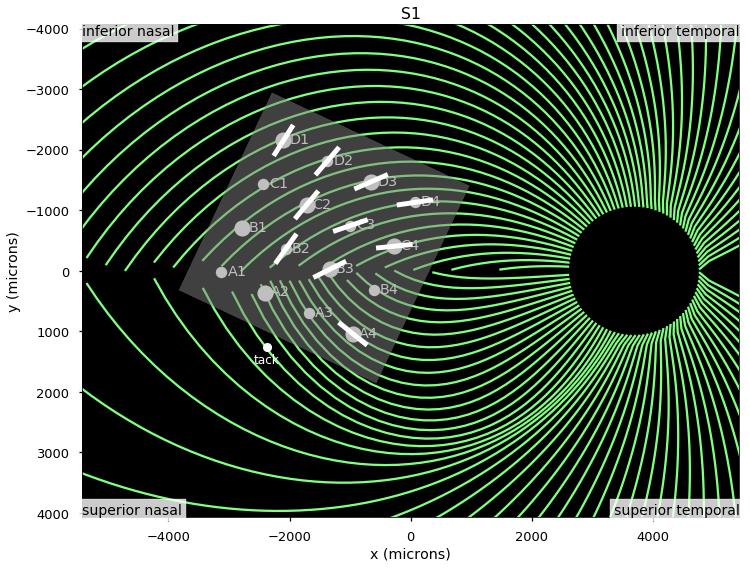

In [6]:
subject = 'S1'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_mean[subject], subjectdata)
fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

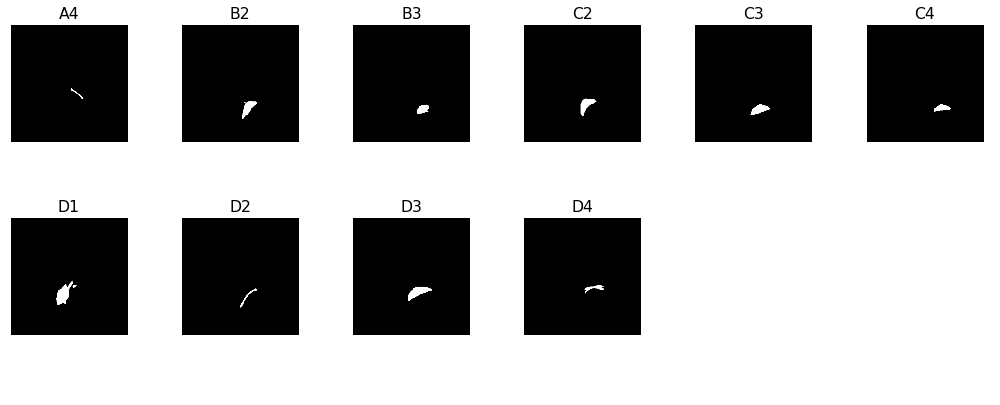

In [7]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)

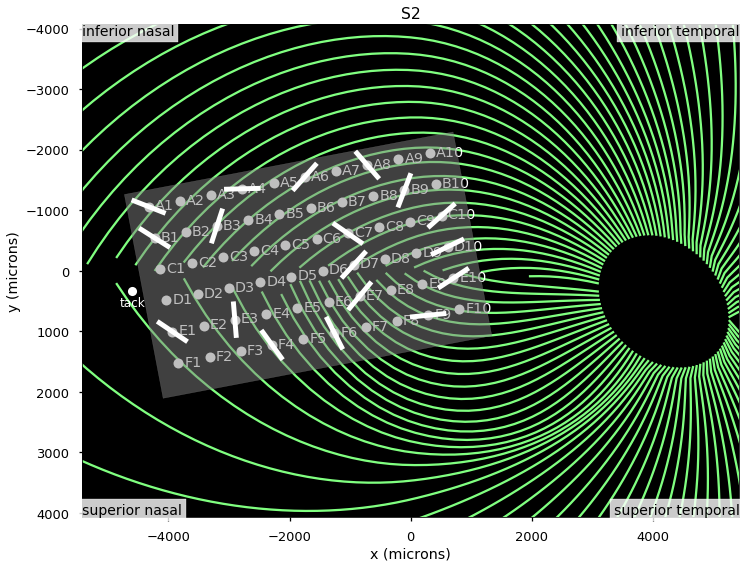

In [8]:
subject = 'S2'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_mean[subject], subjectdata)
fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

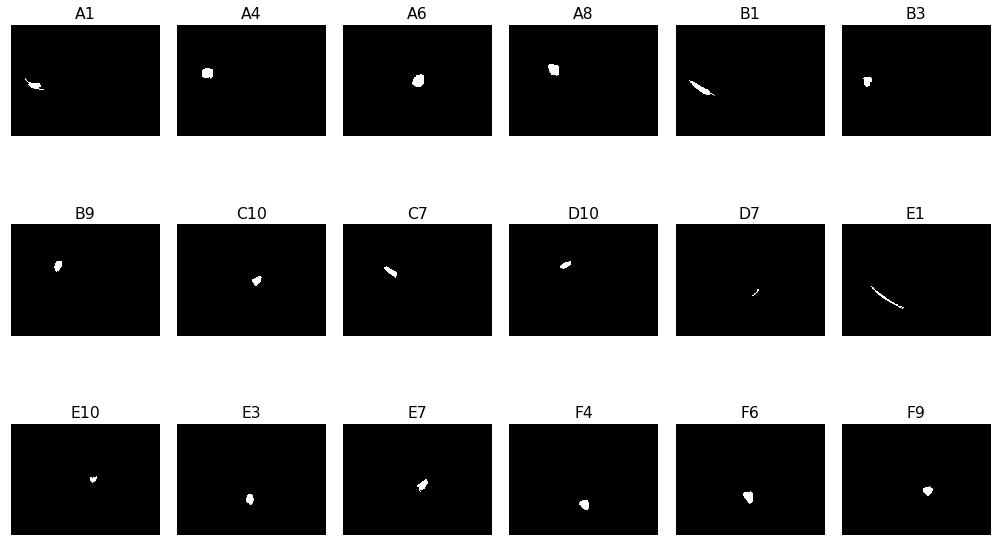

In [9]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)

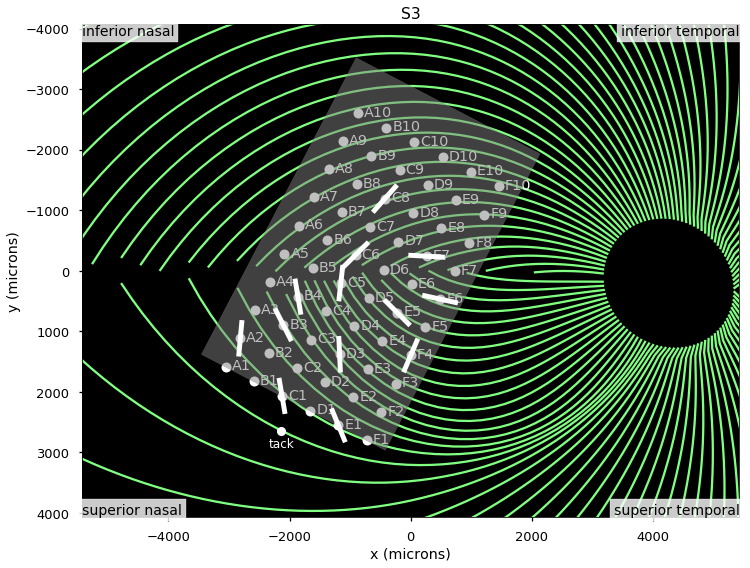

In [10]:
subject = 'S3'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_mean[subject], subjectdata)
fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

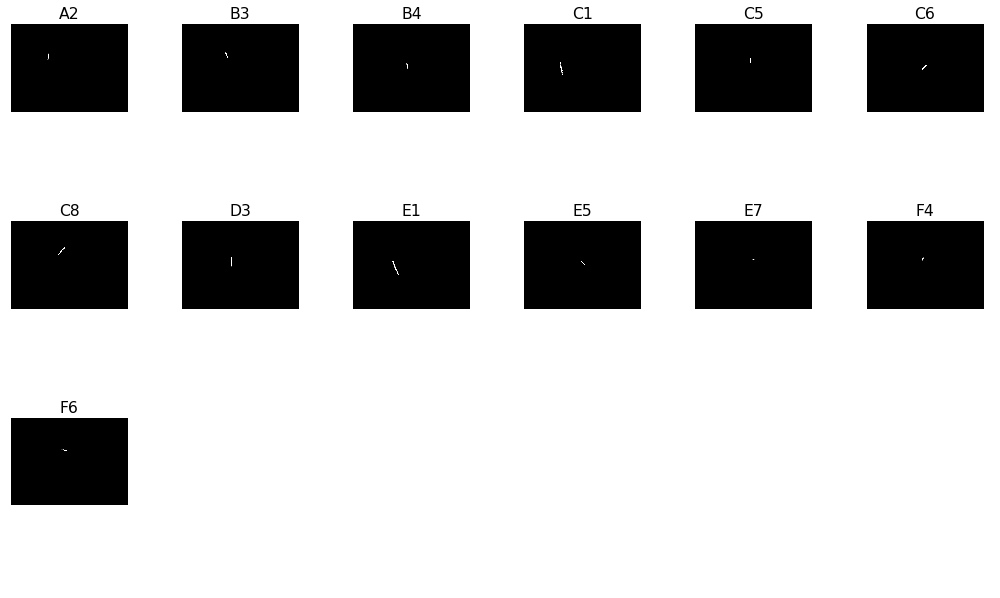

In [11]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)

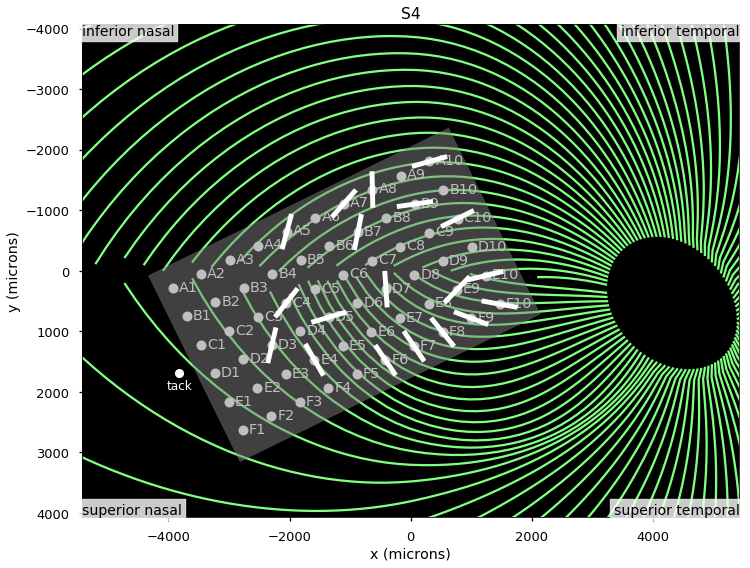

In [12]:
subject = 'S4'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_mean[subject], subjectdata)
fig.tight_layout()
fig.savefig('%s-axons.eps' % subject)

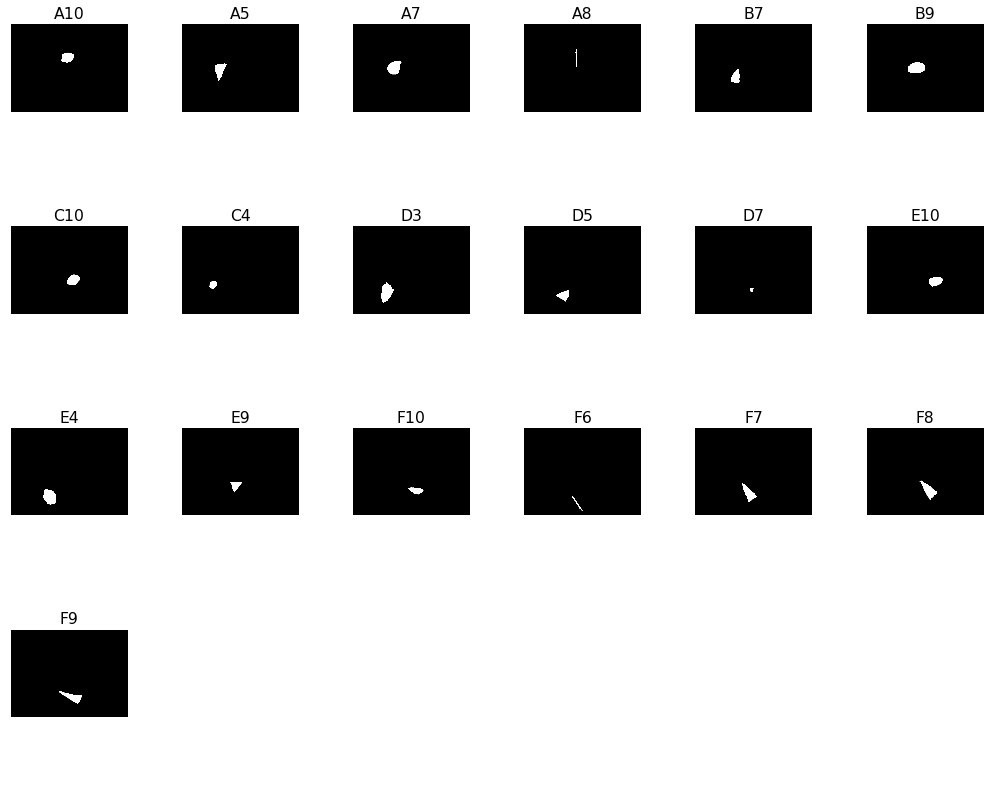

In [13]:
yy = y_mean[subject]
els = yy.electrode.unique()
ncols = 6
nrows = int(np.ceil(len(els) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, 3 * nrows))
for ax in axes.ravel():
    ax.axis('off')
for el, ax in zip(els, axes.ravel()):
    ax.axis('on')
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('%s-axons-drawings.eps' % subject)